In [1]:
import numpy as np
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import tikzplotlib as tkz
import warnings
warnings.filterwarnings("ignore")

import os, sys

_, filename = os.path.split(os.getcwd())
if filename == 'notebooks':
    old_dir = os.getcwd()
    os.chdir('../')
    print('Moving Current Directory from ' + old_dir + ' to ' + os.getcwd())
else:
    print('Current Directory is ' + os.getcwd())

sys.path.append('./')  

from FRB.agents import UCB1Agent, FactoredUCBAgent, TMRobustUCBAgent #, FactoredUCBAgentMM
from FRB.env import FactoredEnv
from FRB.utils import get_pulled_expected, compute_max_expected, create_action_matrix, get_sigma_square_eq_max

Moving Current Directory from /Users/marcomussi/git/FRB/notebooks to /Users/marcomussi/git/FRB


In [2]:
'''
class FactoredUCBAgentMM():
    """
    This class implements the FRB MM optimal algorithm in its anytime
    version for bounded variables
    """
    def __init__(self, n_arms_vect, dim, time_horizon, sigma=0.5,
                 max_reward=1, exploration_alpha=4):
        self.n_arms_vect = n_arms_vect
        self.dim = dim
        self.T = time_horizon
        assert self.dim == self.n_arms_vect.shape[0]
        self.max_reward = max_reward
        self.sigma = sigma
        self.exploration_alpha = exploration_alpha
        self.num_actions = np.prod(self.n_arms_vect)
        self.action_matrix = np.zeros(
            (self.num_actions, dim), dtype=int
        )
        for i in range(self.dim):
            vect = -1 * np.ones(np.prod(self.n_arms_vect[:i+1]))
            external_repeats = int(np.prod(self.n_arms_vect) / len(vect))
            internal_repeats = max(1, int(np.prod(self.n_arms_vect[:i])))
            for j in range(self.n_arms_vect[i]):
                vect[j*internal_repeats:(j+1)*internal_repeats] = j
            vect_new = np.copy(vect).reshape(-1, 1)
            for _ in range(external_repeats-1):
                vect_new = np.vstack((vect_new, vect.reshape(-1, 1)))
            self.action_matrix[:, i] = vect_new.ravel()
        print(self.action_matrix)
        self.reset()

    def reset(self):
        self.t = 1
        self.last_pull = None
        self.n_min_pull = np.zeros(self.num_actions)
        self.n_pulls = []
        self.observations = []
        for size in self.n_arms_vect:
            self.n_pulls.append(np.zeros(size, dtype=int))
            self.observations.append(-1 * np.ones((self.T, size), dtype=int))
        return self

    def pull_arm(self):
        ucb = np.zeros(self.num_actions)
        for i in range(self.num_actions):
            action_vector = self.action_matrix[i, :]
            self.n_min_pull[i] = self.n_pulls[0][action_vector[0]]
            for j in range(1, self.dim):
                self.n_min_pull[i] = min(self.n_min_pull[i], self.n_pulls[j][action_vector[j]])
            virtual_pulls_sum = 0
            for j in range(self.n_min_pull[i]):
                prod_var = 1
                for h in range(self.dim):
                    prod_var *= self.observations[h][j, self.last_pull[h]]
                virtual_pulls_sum += prod_var
            ucb[i] = virtual_pulls_sum / self.n_min_pull[i] + self.sigma * np.sqrt(
                self.exploration_alpha * math.log(self.t) / self.n_min_pull[i])
        print(ucb)
        self.last_pull = self.action_matrix[int(np.argmax(ucb)), :]
        return self.last_pull

    def update(self, observations):
        self.t += 1
        for i in range(self.dim):
            self.observations[i][self.n_pulls[i][self.last_pull[i]], self.last_pull[i]] = observations[i]
            self.n_pulls[i][self.last_pull[i]] = self.n_pulls[i][self.last_pull[i]] + 1  
'''

'\nclass FactoredUCBAgentMM():\n    """\n    This class implements the FRB MM optimal algorithm in its anytime\n    version for bounded variables\n    """\n    def __init__(self, n_arms_vect, dim, time_horizon, sigma=0.5,\n                 max_reward=1, exploration_alpha=4):\n        self.n_arms_vect = n_arms_vect\n        self.dim = dim\n        self.T = time_horizon\n        assert self.dim == self.n_arms_vect.shape[0]\n        self.max_reward = max_reward\n        self.sigma = sigma\n        self.exploration_alpha = exploration_alpha\n        self.num_actions = np.prod(self.n_arms_vect)\n        self.action_matrix = np.zeros(\n            (self.num_actions, dim), dtype=int\n        )\n        for i in range(self.dim):\n            vect = -1 * np.ones(np.prod(self.n_arms_vect[:i+1]))\n            external_repeats = int(np.prod(self.n_arms_vect) / len(vect))\n            internal_repeats = max(1, int(np.prod(self.n_arms_vect[:i])))\n            for j in range(self.n_arms_vect[i]):\n  

In [3]:
class FactoredUCBAgentMM():
    """
    This class implements the FRB MM optimal algorithm in its anytime
    version for bounded variables
    """
    def __init__(self, k, d, time_horizon, sigma=0.5,
                 max_reward=1, exploration_alpha=4):
        self.k = k
        self.d = d
        self.T = time_horizon
        self.max_reward = max_reward
        self.sigma = sigma
        self.exploration_alpha = exploration_alpha
        self.num_actions = self.k ** self.d
        # Creation of the action matrix
        self.action_matrix = np.zeros(
            (self.num_actions, self.d), dtype=int
        )
        for i in range(self.d):
            vect = -1 * np.ones(self.k**(i+1))
            external_repeats = int(self.k**(self.d-(i+1)))
            internal_repeats = self.k**i
            for j in range(self.k):
                vect[j*internal_repeats:(j+1)*internal_repeats] = j
            vect_new = np.copy(vect).reshape(-1, 1)
            for _ in range(external_repeats-1):
                vect_new = np.vstack((vect_new, vect.reshape(-1, 1)))
            self.action_matrix[:, i] = vect_new.ravel()
        # print(self.action_matrix)
        self.reset()

    def reset(self):
        self.t = 1
        self.last_pull = None
        self.n_min_pull = np.zeros(self.num_actions, dtype=int)
        self.n_pulls = np.zeros((self.d, self.k), dtype=int)
        self.observations = -1 * np.ones((self.d, self.k, self.T), dtype=int)
        self.virtual_pulls_sum = np.zeros(self.num_actions)

    def pull_arm(self):
        # ucb = np.zeros(self.num_actions)
        for i in range(self.num_actions):
            action_vector = self.action_matrix[i, :]
            new_min_pull = self.n_pulls[0, action_vector[0]]
            for j in range(1, self.d):
                new_min_pull = min(new_min_pull, self.n_pulls[j, action_vector[j]])
            if new_min_pull != self.n_min_pull[i]:
                self.n_min_pull[i] = new_min_pull
                aux = 1
                for j in range(self.d):
                    aux *= self.observations[j, self.last_pull[j], self.n_min_pull[i]-1]
                self.virtual_pulls_sum[i] += aux
        mean = self.virtual_pulls_sum / self.n_min_pull
        ucb = mean + self.sigma * np.sqrt(self.exploration_alpha * math.log(self.t) / self.n_min_pull)
        self.last_pull = self.action_matrix[int(np.argmax(ucb)), :]
        return self.last_pull

    def update(self, observations):
        self.t += 1
        for i in range(self.d):
            self.observations[i, self.last_pull[i], self.n_pulls[i, self.last_pull[i]]] = observations[i]
            self.n_pulls[i, self.last_pull[i]] = self.n_pulls[i, self.last_pull[i]] + 1

  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=1 $\sigma$=0.5
T=1000: $25.61 \ (1.0)$
T=5000: $51.25 \ (2.6)$
T=10000: $65.3 \ (3.9)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=1 $\sigma$=0.5
T=1000: $25.6 \ (1.01)$
T=5000: $51.35 \ (2.59)$
T=10000: $65.19 \ (3.91)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=1 $\sigma$=0.5
T=1000: $25.61 \ (1.0)$
T=5000: $51.25 \ (2.6)$
T=10000: $65.3 \ (3.9)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=3 d=1 $\sigma$=0.5
T=1000: $117.94 \ (6.28)$
T=5000: $377.0 \ (14.51)$
T=10000: $575.0 \ (18.42)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=4 d=1 $\sigma$=0.5
T=1000: $37.06 \ (1.18)$
T=5000: $75.48 \ (3.36)$
T=10000: $99.27 \ (4.72)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=4 d=1 $\sigma$=0.5
T=1000: $36.92 \ (1.17)$
T=5000: $76.02 \ (3.56)$
T=10000: $99.47 \ (4.9)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=4 d=1 $\sigma$=0.5
T=1000: $37.06 \ (1.18)$
T=5000: $75.48 \ (3.36)$
T=10000: $99.27 \ (4.72)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=4 d=1 $\sigma$=0.5
T=1000: $144.86 \ (6.9)$
T=5000: $499.04 \ (18.59)$
T=10000: $780.95 \ (24.02)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=5 d=1 $\sigma$=0.5
T=1000: $46.67 \ (1.01)$
T=5000: $93.23 \ (2.83)$
T=10000: $118.27 \ (4.42)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=5 d=1 $\sigma$=0.5
T=1000: $46.77 \ (0.97)$
T=5000: $93.05 \ (2.95)$
T=10000: $117.8 \ (4.52)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=5 d=1 $\sigma$=0.5
T=1000: $46.67 \ (1.01)$
T=5000: $93.23 \ (2.83)$
T=10000: $118.27 \ (4.42)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=5 d=1 $\sigma$=0.5
T=1000: $178.52 \ (6.84)$
T=5000: $640.81 \ (21.79)$
T=10000: $1013.28 \ (29.75)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=2 $\sigma$=0.5
T=1000: $44.65 \ (1.24)$
T=5000: $87.24 \ (2.66)$
T=10000: $111.55 \ (4.17)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=2 $\sigma$=0.5
T=1000: $127.48 \ (14.51)$
T=5000: $512.17 \ (69.49)$
T=10000: $969.79 \ (138.09)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=2 $\sigma$=0.5
T=1000: $99.05 \ (11.05)$
T=5000: $300.46 \ (56.14)$
T=10000: $510.31 \ (111.08)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=3 d=2 $\sigma$=0.5
T=1000: $218.0 \ (11.02)$
T=5000: $880.79 \ (48.54)$
T=10000: $1518.28 \ (97.52)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=4 d=2 $\sigma$=0.5
T=1000: $64.03 \ (1.98)$
T=5000: $125.88 \ (3.93)$
T=10000: $162.09 \ (5.31)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=4 d=2 $\sigma$=0.5
T=1000: $123.01 \ (13.01)$
T=5000: $453.01 \ (67.83)$
T=10000: $846.06 \ (136.8)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=4 d=2 $\sigma$=0.5
T=1000: $128.04 \ (12.0)$
T=5000: $404.63 \ (61.41)$
T=10000: $693.41 \ (121.64)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=4 d=2 $\sigma$=0.5
T=1000: $264.85 \ (12.1)$
T=5000: $1106.69 \ (53.36)$
T=10000: $1943.66 \ (106.97)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=5 d=2 $\sigma$=0.5
T=1000: $83.73 \ (1.81)$
T=5000: $165.56 \ (4.05)$
T=10000: $213.49 \ (6.58)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=5 d=2 $\sigma$=0.5
T=1000: $162.88 \ (13.63)$
T=5000: $573.04 \ (65.84)$
T=10000: $1046.43 \ (129.32)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=5 d=2 $\sigma$=0.5
T=1000: $172.01 \ (15.05)$
T=5000: $575.82 \ (77.56)$
T=10000: $1016.49 \ (154.19)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=5 d=2 $\sigma$=0.5
T=1000: $308.8 \ (14.12)$
T=5000: $1353.7 \ (68.88)$
T=10000: $2447.43 \ (139.31)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=3 $\sigma$=0.5
T=1000: $51.66 \ (1.88)$
T=5000: $103.67 \ (3.89)$
T=10000: $130.95 \ (5.37)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=3 $\sigma$=0.5
T=1000: $142.14 \ (13.23)$
T=5000: $534.71 \ (67.04)$
T=10000: $955.86 \ (123.77)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=3 $\sigma$=0.5
T=1000: $210.43 \ (19.01)$
T=5000: $880.13 \ (95.1)$
T=10000: $1641.97 \ (190.3)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=3 d=3 $\sigma$=0.5
T=1000: $277.61 \ (19.71)$
T=5000: $1300.12 \ (95.92)$
T=10000: $2483.36 \ (190.2)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=4 d=3 $\sigma$=0.5
T=1000: $78.36 \ (2.25)$
T=5000: $158.91 \ (4.63)$
T=10000: $204.81 \ (6.47)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=4 d=3 $\sigma$=0.5
T=1000: $176.0 \ (10.62)$
T=5000: $564.04 \ (54.95)$
T=10000: $980.35 \ (109.07)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=4 d=3 $\sigma$=0.5
T=1000: $280.86 \ (20.32)$
T=5000: $1183.82 \ (107.8)$
T=10000: $2217.53 \ (217.43)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=4 d=3 $\sigma$=0.5
T=1000: $340.35 \ (18.51)$
T=5000: $1628.77 \ (94.38)$
T=10000: $3150.69 \ (192.09)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=5 d=3 $\sigma$=0.5
T=1000: $104.88 \ (2.49)$
T=5000: $214.88 \ (5.2)$
T=10000: $274.16 \ (7.57)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=5 d=3 $\sigma$=0.5
T=1000: $248.56 \ (15.53)$
T=5000: $810.9 \ (75.49)$
T=10000: $1395.04 \ (147.59)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=5 d=3 $\sigma$=0.5
T=1000: $328.22 \ (19.28)$
T=5000: $1385.42 \ (104.27)$
T=10000: $2586.55 \ (211.12)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=5 d=3 $\sigma$=0.5
T=1000: $396.65 \ (17.87)$
T=5000: $1901.5 \ (90.04)$
T=10000: $3683.9 \ (182.26)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=4 $\sigma$=0.5
T=1000: $54.1 \ (2.17)$
T=5000: $109.61 \ (4.26)$
T=10000: $141.67 \ (5.39)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=4 $\sigma$=0.5
T=1000: $173.18 \ (13.91)$
T=5000: $627.08 \ (69.6)$
T=10000: $1123.03 \ (139.34)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=4 $\sigma$=0.5
T=1000: $231.93 \ (15.56)$
T=5000: $1002.83 \ (79.82)$
T=10000: $1886.23 \ (158.47)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=3 d=4 $\sigma$=0.5
T=1000: $272.18 \ (16.0)$
T=5000: $1318.72 \ (78.73)$
T=10000: $2571.6 \ (156.35)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=4 d=4 $\sigma$=0.5
T=1000: $88.49 \ (2.59)$
T=5000: $180.25 \ (5.19)$
T=10000: $234.08 \ (7.57)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=4 d=4 $\sigma$=0.5
T=1000: $257.7 \ (13.24)$
T=5000: $898.2 \ (65.45)$
T=10000: $1567.38 \ (132.54)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=4 d=4 $\sigma$=0.5
T=1000: $324.24 \ (19.14)$
T=5000: $1466.54 \ (101.73)$
T=10000: $2791.08 \ (206.32)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=4 d=4 $\sigma$=0.5
T=1000: $358.97 \ (17.69)$
T=5000: $1756.4 \ (89.84)$
T=10000: $3458.38 \ (181.93)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=5 d=4 $\sigma$=0.5
T=1000: $117.6 \ (3.48)$
T=5000: $247.53 \ (6.58)$
T=10000: $318.79 \ (8.67)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=5 d=4 $\sigma$=0.5
T=1000: $316.29 \ (17.18)$
T=5000: $1134.93 \ (87.45)$
T=10000: $1882.25 \ (158.54)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=5 d=4 $\sigma$=0.5
T=1000: $381.58 \ (20.25)$
T=5000: $1741.2 \ (105.7)$
T=10000: $3319.16 \ (213.61)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=5 d=4 $\sigma$=0.5
T=1000: $413.28 \ (19.76)$
T=5000: $2034.95 \ (99.14)$
T=10000: $4023.06 \ (199.04)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=1 $\sigma$=0.1
T=1000: $2.72 \ (0.2)$
T=5000: $4.44 \ (0.47)$
T=10000: $5.52 \ (0.67)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=1 $\sigma$=0.1
T=1000: $92.98 \ (9.89)$
T=5000: $333.95 \ (44.7)$
T=10000: $569.35 \ (83.81)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=1 $\sigma$=0.1
T=1000: $2.72 \ (0.2)$
T=5000: $4.44 \ (0.47)$
T=10000: $5.52 \ (0.67)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=3 d=1 $\sigma$=0.1
T=1000: $116.96 \ (6.26)$
T=5000: $376.82 \ (14.58)$
T=10000: $575.02 \ (18.17)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=4 d=1 $\sigma$=0.1
T=1000: $4.33 \ (0.24)$
T=5000: $6.82 \ (0.47)$
T=10000: $8.58 \ (0.79)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=4 d=1 $\sigma$=0.1
T=1000: $108.13 \ (10.9)$
T=5000: $393.52 \ (53.04)$
T=10000: $677.67 \ (101.55)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=4 d=1 $\sigma$=0.1
T=1000: $4.33 \ (0.24)$
T=5000: $6.82 \ (0.47)$
T=10000: $8.58 \ (0.79)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=4 d=1 $\sigma$=0.1
T=1000: $145.73 \ (6.85)$
T=5000: $499.85 \ (18.78)$
T=10000: $782.31 \ (24.41)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=5 d=1 $\sigma$=0.1
T=1000: $5.18 \ (0.22)$
T=5000: $7.73 \ (0.52)$
T=10000: $9.16 \ (0.7)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=5 d=1 $\sigma$=0.1
T=1000: $119.95 \ (11.85)$
T=5000: $402.57 \ (57.75)$
T=10000: $672.0 \ (110.9)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=5 d=1 $\sigma$=0.1
T=1000: $5.18 \ (0.22)$
T=5000: $7.73 \ (0.52)$
T=10000: $9.16 \ (0.7)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=5 d=1 $\sigma$=0.1
T=1000: $178.26 \ (6.87)$
T=5000: $640.03 \ (21.48)$
T=10000: $1016.67 \ (29.11)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=2 $\sigma$=0.1
T=1000: $4.67 \ (0.2)$
T=5000: $7.14 \ (0.48)$
T=10000: $8.41 \ (0.66)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=2 $\sigma$=0.1
T=1000: $253.81 \ (13.7)$
T=5000: $1234.03 \ (71.47)$
T=10000: $2439.68 \ (148.15)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=2 $\sigma$=0.1
T=1000: $42.19 \ (10.99)$
T=5000: $186.56 \ (54.39)$
T=10000: $364.8 \ (108.53)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=3 d=2 $\sigma$=0.1
T=1000: $219.14 \ (11.05)$
T=5000: $884.31 \ (48.42)$
T=10000: $1524.1 \ (97.12)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=4 d=2 $\sigma$=0.1
T=1000: $6.97 \ (0.31)$
T=5000: $10.71 \ (0.58)$
T=10000: $12.67 \ (0.76)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=4 d=2 $\sigma$=0.1
T=1000: $299.86 \ (16.43)$
T=5000: $1477.77 \ (87.81)$
T=10000: $2927.11 \ (179.11)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=4 d=2 $\sigma$=0.1
T=1000: $57.72 \ (12.01)$
T=5000: $255.84 \ (59.68)$
T=10000: $500.61 \ (119.1)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=4 d=2 $\sigma$=0.1
T=1000: $264.68 \ (12.09)$
T=5000: $1107.97 \ (53.69)$
T=10000: $1947.23 \ (106.81)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=5 d=2 $\sigma$=0.1
T=1000: $9.38 \ (0.35)$
T=5000: $14.1 \ (0.71)$
T=10000: $16.89 \ (0.98)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=5 d=2 $\sigma$=0.1
T=1000: $345.61 \ (15.11)$
T=5000: $1658.37 \ (78.59)$
T=10000: $3229.14 \ (168.04)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=5 d=2 $\sigma$=0.1
T=1000: $87.39 \ (15.22)$
T=5000: $396.13 \ (75.5)$
T=10000: $778.71 \ (150.81)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=5 d=2 $\sigma$=0.1
T=1000: $309.58 \ (14.15)$
T=5000: $1355.17 \ (68.83)$
T=10000: $2448.84 \ (139.1)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=3 $\sigma$=0.1
T=1000: $5.43 \ (0.24)$
T=5000: $8.49 \ (0.48)$
T=10000: $10.17 \ (0.75)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=3 $\sigma$=0.1
T=1000: $289.27 \ (16.37)$
T=5000: $1438.89 \ (80.42)$
T=10000: $2860.4 \ (158.32)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=3 $\sigma$=0.1
T=1000: $148.88 \ (18.9)$
T=5000: $699.71 \ (94.05)$
T=10000: $1381.59 \ (187.85)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=3 d=3 $\sigma$=0.1
T=1000: $277.12 \ (19.72)$
T=5000: $1299.32 \ (96.16)$
T=10000: $2478.67 \ (190.41)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=4 d=3 $\sigma$=0.1
T=1000: $8.85 \ (0.39)$
T=5000: $14.12 \ (0.82)$
T=10000: $16.52 \ (1.02)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=4 d=3 $\sigma$=0.1
T=1000: $348.95 \ (16.8)$
T=5000: $1731.87 \ (83.2)$
T=10000: $3453.96 \ (165.76)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=4 d=3 $\sigma$=0.1
T=1000: $202.13 \ (21.45)$
T=5000: $951.77 \ (106.4)$
T=10000: $1880.39 \ (212.38)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=4 d=3 $\sigma$=0.1
T=1000: $340.0 \ (18.54)$
T=5000: $1628.15 \ (94.36)$
T=10000: $3151.5 \ (191.69)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=5 d=3 $\sigma$=0.1
T=1000: $11.98 \ (0.45)$
T=5000: $18.36 \ (0.92)$
T=10000: $21.63 \ (1.14)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=5 d=3 $\sigma$=0.1
T=1000: $411.8 \ (18.16)$
T=5000: $2044.02 \ (91.02)$
T=10000: $4067.94 \ (183.02)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=5 d=3 $\sigma$=0.1
T=1000: $235.9 \ (21.03)$
T=5000: $1110.88 \ (104.76)$
T=10000: $2193.9 \ (209.1)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=5 d=3 $\sigma$=0.1
T=1000: $397.0 \ (17.84)$
T=5000: $1902.34 \ (89.67)$
T=10000: $3684.07 \ (181.57)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=3 d=4 $\sigma$=0.1
T=1000: $6.13 \ (0.26)$
T=5000: $9.58 \ (0.55)$
T=10000: $11.63 \ (0.75)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=3 d=4 $\sigma$=0.1
T=1000: $279.72 \ (16.47)$
T=5000: $1398.57 \ (82.32)$
T=10000: $2797.14 \ (164.64)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=3 d=4 $\sigma$=0.1
T=1000: $171.85 \ (15.59)$
T=5000: $799.05 \ (77.62)$
T=10000: $1571.24 \ (154.96)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=3 d=4 $\sigma$=0.1
T=1000: $272.43 \ (15.96)$
T=5000: $1318.71 \ (78.49)$
T=10000: $2571.89 \ (155.9)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=4 d=4 $\sigma$=0.1
T=1000: $9.84 \ (0.4)$
T=5000: $16.02 \ (0.85)$
T=10000: $18.68 \ (1.08)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=4 d=4 $\sigma$=0.1
T=1000: $364.15 \ (15.66)$
T=5000: $1820.75 \ (78.29)$
T=10000: $3641.49 \ (156.58)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=4 d=4 $\sigma$=0.1
T=1000: $258.19 \ (20.65)$
T=5000: $1209.66 \ (102.69)$
T=10000: $2383.95 \ (204.77)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=4 d=4 $\sigma$=0.1
T=1000: $358.91 \ (17.68)$
T=5000: $1756.99 \ (89.77)$
T=10000: $3459.8 \ (181.73)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshort run completed - k=5 d=4 $\sigma$=0.1
T=1000: $13.74 \ (0.49)$
T=5000: $20.96 \ (0.88)$
T=10000: $24.5 \ (1.12)$


  0%|          | 0/50 [00:00<?, ?it/s]

\JPAalgnameshortMM run completed - k=5 d=4 $\sigma$=0.1
T=1000: $427.76 \ (19.69)$
T=5000: $2138.63 \ (98.43)$
T=10000: $4277.19 \ (196.86)$


  0%|          | 0/50 [00:00<?, ?it/s]

\ucbone run completed - k=5 d=4 $\sigma$=0.1
T=1000: $306.4 \ (21.47)$
T=5000: $1440.24 \ (106.57)$
T=10000: $2840.05 \ (212.48)$


  0%|          | 0/50 [00:00<?, ?it/s]

\httem run completed - k=5 d=4 $\sigma$=0.1
T=1000: $413.14 \ (19.78)$
T=5000: $2034.1 \ (99.08)$
T=10000: $4021.3 \ (198.53)$


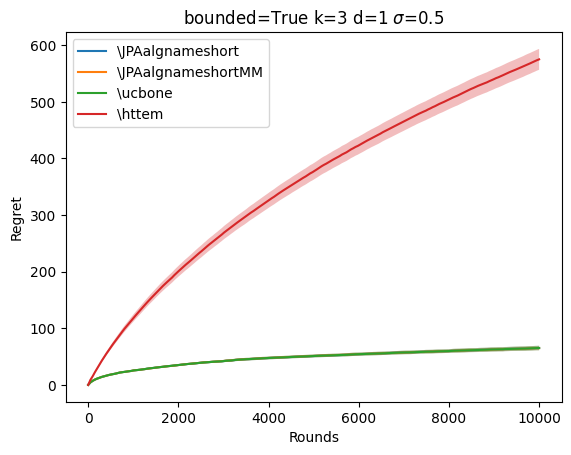

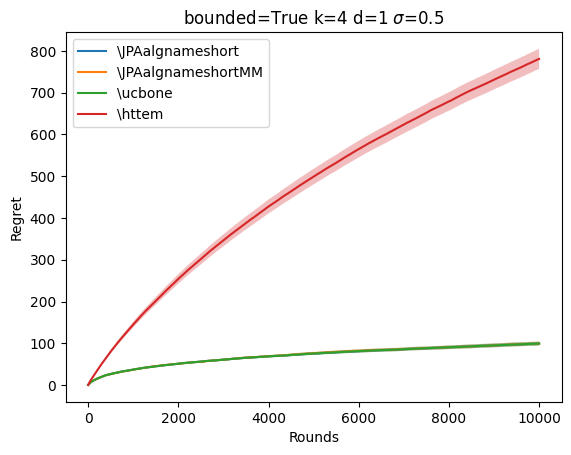

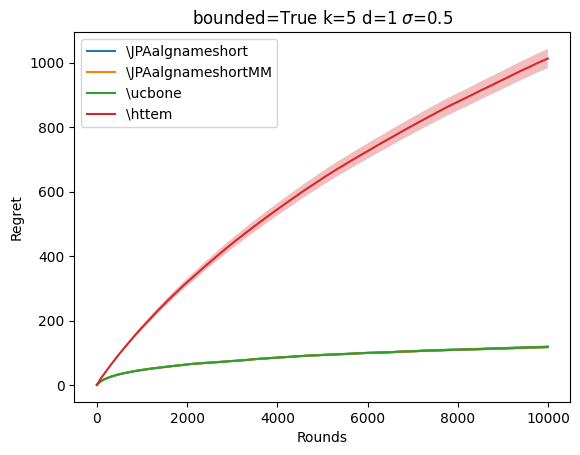

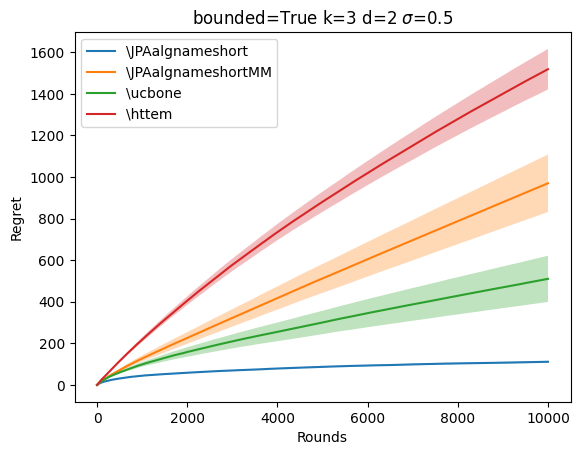

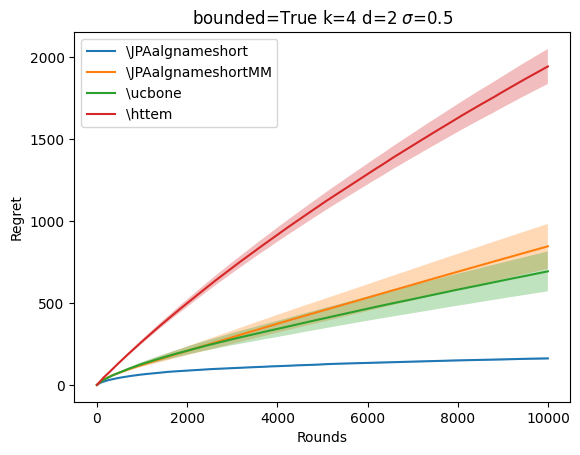

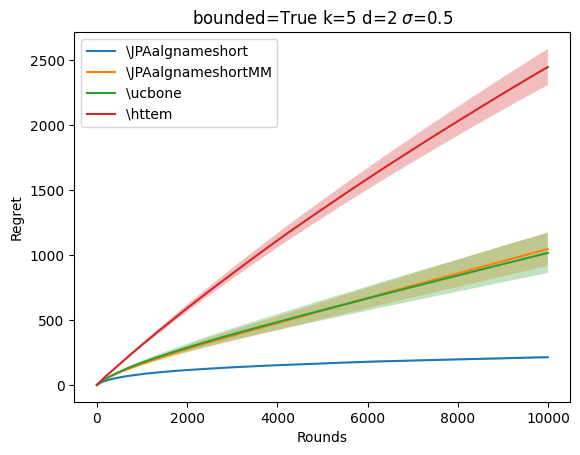

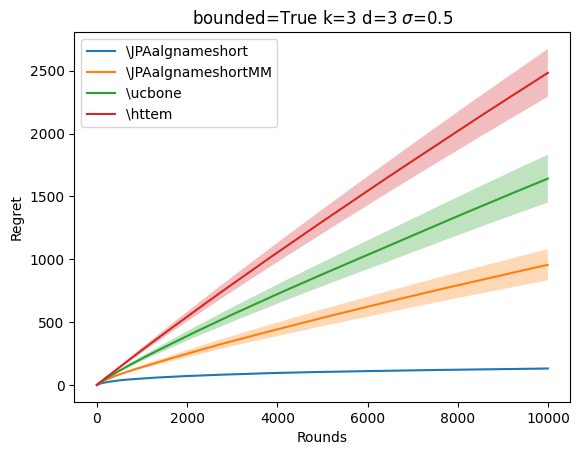

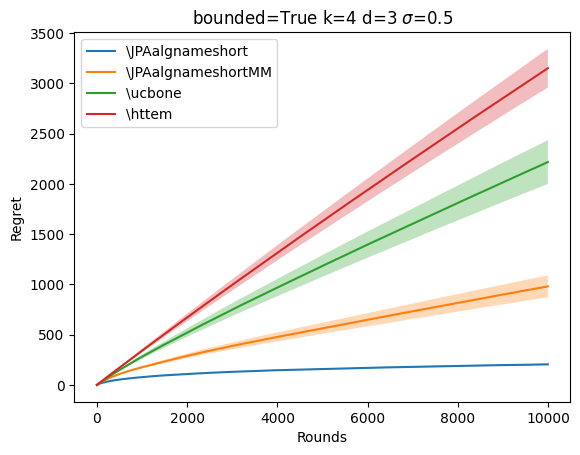

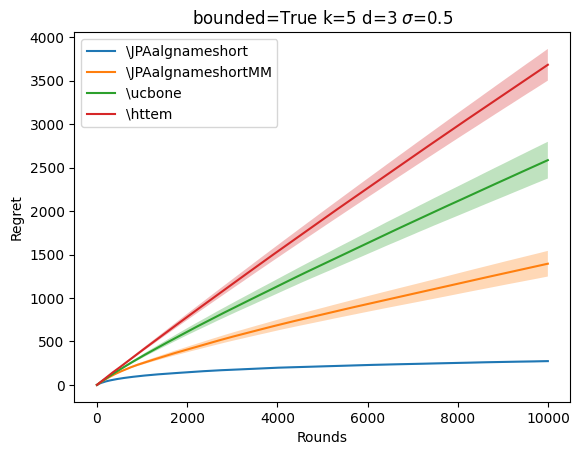

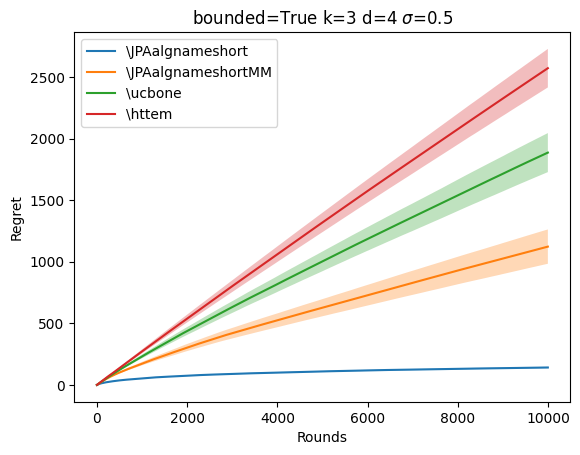

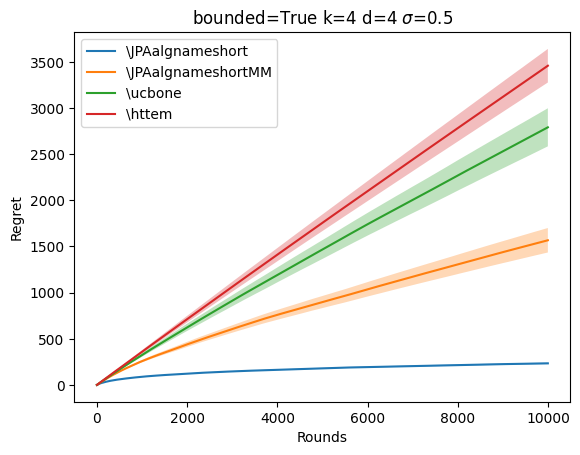

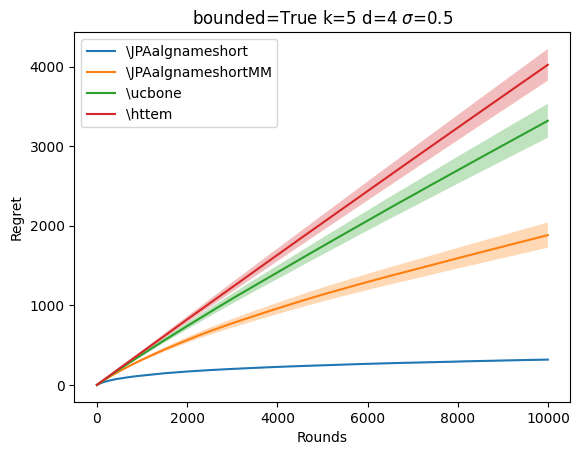

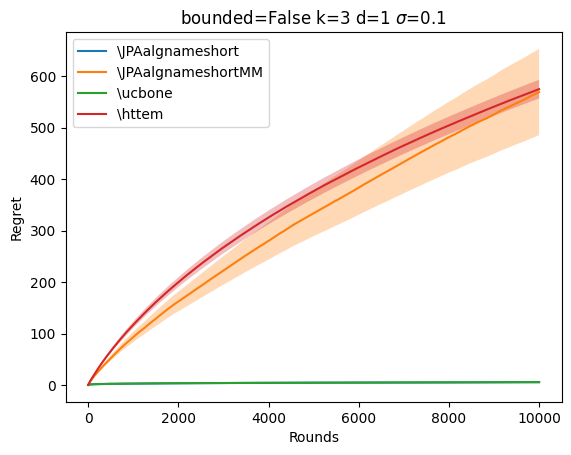

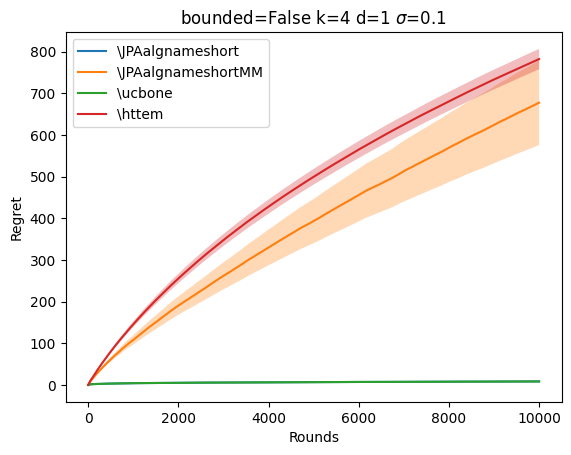

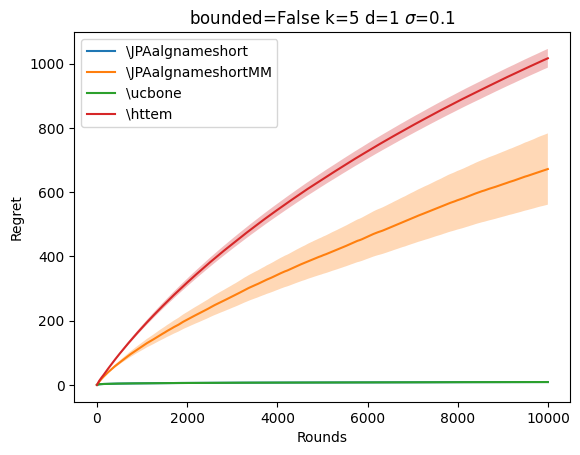

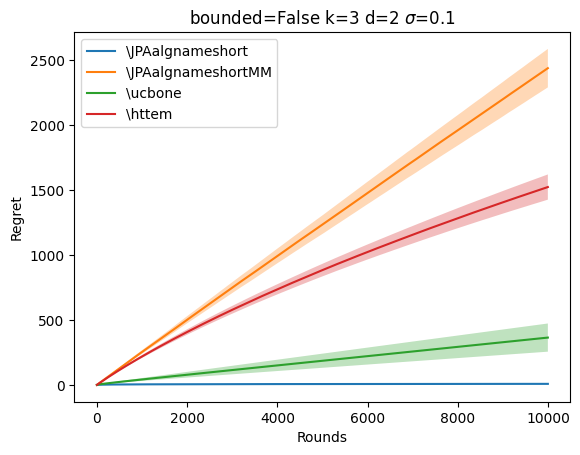

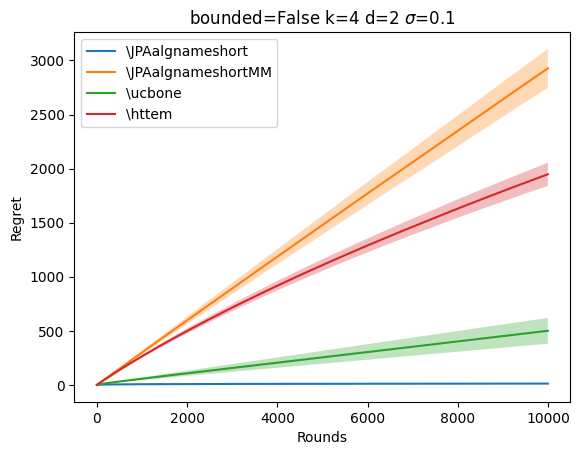

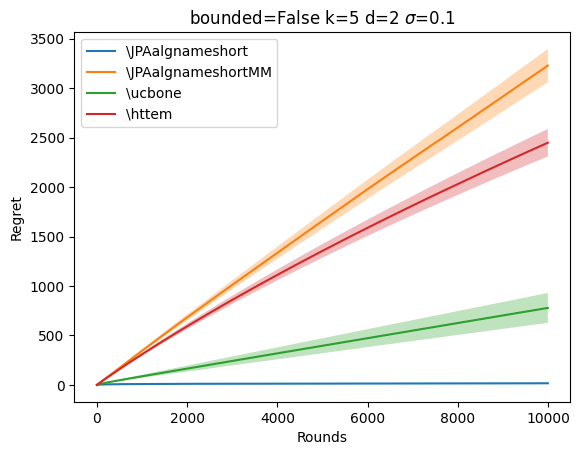

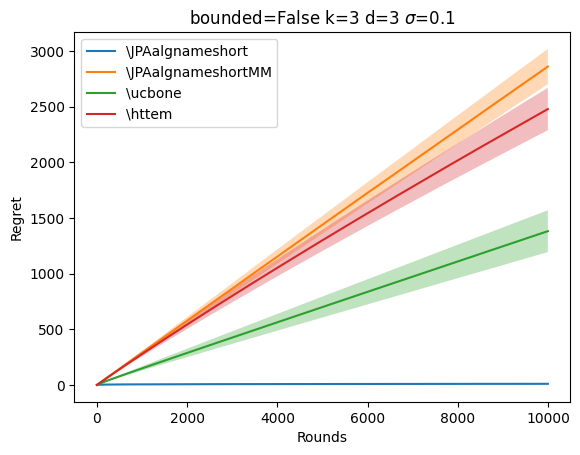

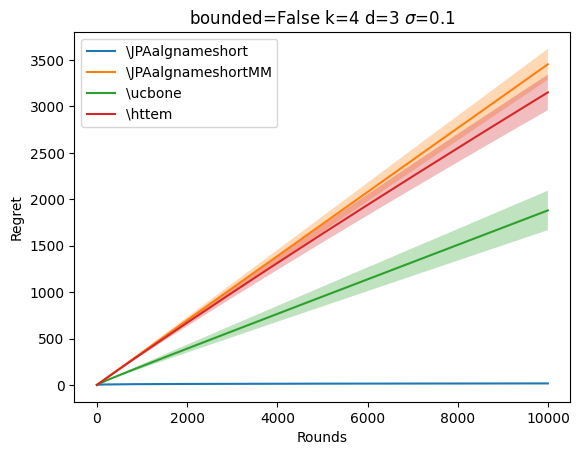

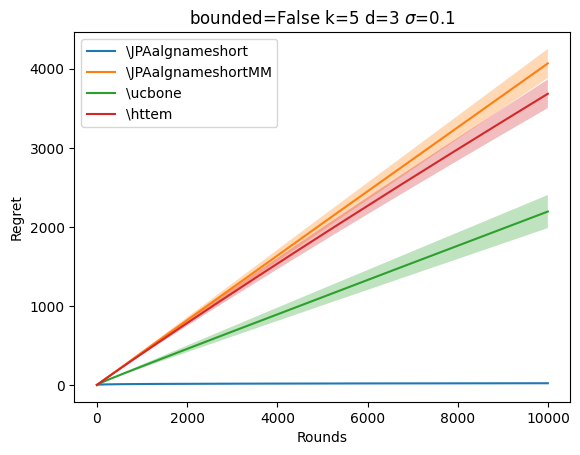

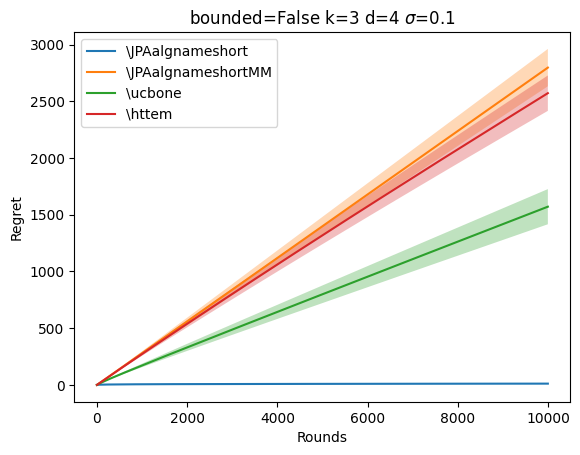

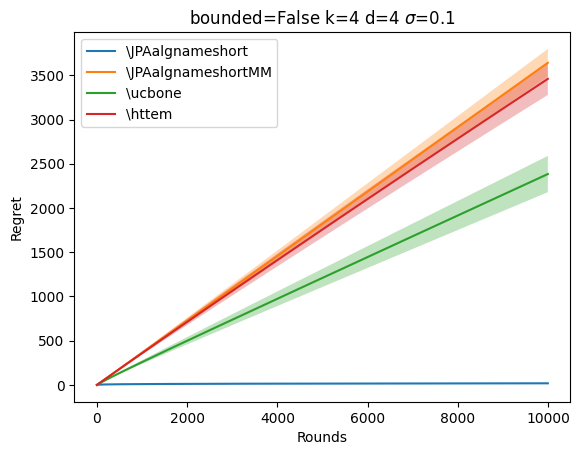

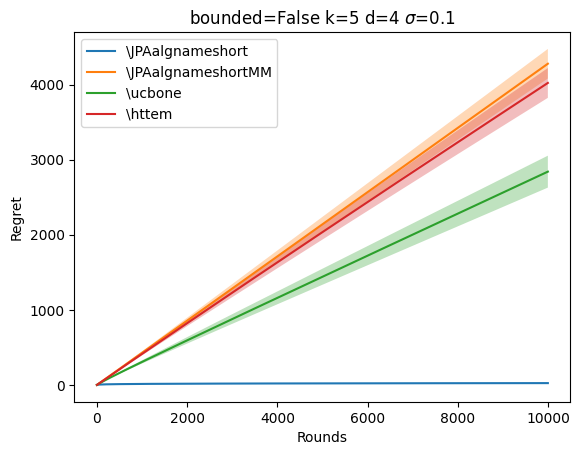

In [4]:
# BASIC SETTING FOR EXPERIMENTS
fucb = '\\JPAalgnameshort'
fucbMM = '\\JPAalgnameshortMM'
ucbone = '\\ucbone'
httem = '\\httem'
algs = [fucb, fucbMM, ucbone, httem]
T = 10000
checkpoints = [1000, 5000, 10000]
n_trials = 50
seed = 0
k_list = [3, 4, 5]
d_list = [1, 2, 3, 4]
bounded_list = [True, False]   
do_subsampling = True

# OVERRIDE FOR TESTING PURPOSE TO SPEED UP THE RUNS
# T = 10000
# checkpoints = [1000, 2000, 5000]
# bounded_list = [True] 
# algs = [fucb, fucbMM, ucbone]
# n_trials = 4
# k_list = [2, 3]
# d_list = [1, 2, 3]
# do_subsampling = False
    
result_table = {}

for bounded in bounded_list:

    result_table[bounded] = {}
    
    if bounded: 
        sigma = 0.5 # fixed for bernoulli
    else:
        sigma = 0.1
    
    for d in d_list:

        result_table[bounded][d] = {}

        for k in k_list:

            result_table[bounded][d][k] = {}

            arms_vect = k * np.ones(d, dtype=int)

            # F-UCB INIT
            agent_factored = FactoredUCBAgent(arms_vect, d, sigma)

            # F-UCB-MM INIT
            agent_factored_MM = FactoredUCBAgentMM(k, d, T)
            
            # UCB1 INIT
            agent_ucb = UCB1Agent(d*k, sigma)
            action_mx = create_action_matrix(d, k)

            # HT-TEM INIT
            agent_ht_tem = TMRobustUCBAgent(d*k, 1, 1)
            
            mean_cum_expected_regret = {}
            std_cum_expected_regret = {}
            
            for alg in algs:

                result_table[bounded][d][k][alg] = {}

                env = FactoredEnv(arms_vect, d, sigma=sigma, bounded=bounded)

                inst_expected_regret = np.zeros((n_trials, T))
                
                # for trial_i in range(n_trials):
                for trial_i in tqdm(range(n_trials)):
                
                    vals_expected = env.get_expected()
                    max_expected = compute_max_expected(vals_expected)

                    for t in range(T):

                        if alg == ucbone:
                            action = action_mx[agent_ucb.pull_arm(), :]
                            agent_ucb.update(np.prod(env.step(action)))
                        elif alg == fucb:
                            action = agent_factored.pull_arm()
                            agent_factored.update(env.step(action))
                        elif alg == fucbMM:
                            action = agent_factored_MM.pull_arm()
                            agent_factored_MM.update(env.step(action))
                        elif alg == httem:
                            action = action_mx[agent_ht_tem.pull_arm(), :]
                            agent_ht_tem.update(np.prod(env.step(action)))
                        else:
                            raise ValueError('Error in selecting algorithm')

                        inst_expected_regret[trial_i, t] = max_expected - get_pulled_expected(
                            vals_expected, action)
                    
                    # I reset all the agents, becuase i do not know which one 
                    # i am using for the sake of simplicity
                    agent_ucb.reset()
                    agent_factored.reset()
                    agent_factored_MM.reset()
                    agent_ht_tem.reset()
                    
                    if trial_i < n_trials - 1:
                        env.reset()
                
                # maybe replace with cumsum with correct axis
                cum_expected_regret = np.zeros(inst_expected_regret.shape)
                cum_expected_regret[:, 0] = inst_expected_regret[:, 0]
                for i in range(1, T):
                    cum_expected_regret[:, i] = inst_expected_regret[:, i] + cum_expected_regret[:, i-1]

                mean_cum_expected_regret[alg] = np.mean(cum_expected_regret, axis=0)
                std_cum_expected_regret[alg] = np.std(cum_expected_regret, axis=0) / np.sqrt(n_trials)

                print('{} run completed - k={} d={} $\sigma$={}'.format(alg, k, d, sigma))
                for i in checkpoints:
                    result_table[bounded][d][k][alg][i] = '${} \ ({})$   '.format(
                        round(mean_cum_expected_regret[alg][i-1], 2), 
                        round(std_cum_expected_regret[alg][i-1], 2)
                    )
                    print('T={}: ${} \ ({})$'.format(i, round(mean_cum_expected_regret[alg][i-1], 2), 
                                                  round(std_cum_expected_regret[alg][i-1], 2)))

            plt.figure()
            if do_subsampling:
                subsample = 50
                assert T % subsample == 0
                x_plt = np.linspace(0, T-1, int(T/subsample), dtype=int)
            else:
                x_plt = np.linspace(0, T-1, T, dtype=int)
            for alg in algs:
                plt.plot(x_plt, mean_cum_expected_regret[alg][x_plt], 
                         label=alg)
                plt.fill_between(x_plt, 
                                 mean_cum_expected_regret[alg][x_plt] - std_cum_expected_regret[alg][x_plt], 
                                 mean_cum_expected_regret[alg][x_plt] + std_cum_expected_regret[alg][x_plt], 
                                 alpha=0.3)
            plt.legend()
            plt.xlabel('Rounds')
            plt.ylabel('Regret')
            plt.title('bounded={} k={} d={} $\sigma$={}'.format(bounded, k, d, sigma))
            if bounded:
                save_str = 'results/bounded_k{}_d{}'.format(k, d)
            else:
                save_str = 'results/subgauss_k{}_d{}'.format(k, d)
            # plt.savefig(save_str + '.png')
            # tkz.save(save_str + '.tex')

In [7]:
print('d= \t k= \t T=\t\t', end='')
[print(alg, end='\t\t\t') for alg in algs]
print('')

for d in d_list:
    for k in k_list:
        for T_val in checkpoints:
            print('${}$ & \t ${}$ & \t ${}$ \t\t'.format(d, k, T_val), end='')
            for bounded in bounded_list:
                for alg in algs:
                    print('&', result_table[bounded][d][k][alg][T_val], end='\t')
            if T_val == checkpoints[-1]:
                print('\\\\\n\\cmidrule{2-10}')
            else:
                print('\\\\\n\\cmidrule{3-10}')
    print('\cmidrule{1-10}')

d= 	 k= 	 T=		\JPAalgnameshort			\JPAalgnameshortMM			\ucbone			\httem			
$1$ & 	 $3$ & 	 $1000$ 		& $25.61 \ (1.0)$   	& $25.6 \ (1.01)$   	& $25.61 \ (1.0)$   	& $117.94 \ (6.28)$   	& $2.72 \ (0.2)$   	& $92.98 \ (9.89)$   	& $2.72 \ (0.2)$   	& $116.96 \ (6.26)$   	\\
\cmidrule{3-10}
$1$ & 	 $3$ & 	 $5000$ 		& $51.25 \ (2.6)$   	& $51.35 \ (2.59)$   	& $51.25 \ (2.6)$   	& $377.0 \ (14.51)$   	& $4.44 \ (0.47)$   	& $333.95 \ (44.7)$   	& $4.44 \ (0.47)$   	& $376.82 \ (14.58)$   	\\
\cmidrule{3-10}
$1$ & 	 $3$ & 	 $10000$ 		& $65.3 \ (3.9)$   	& $65.19 \ (3.91)$   	& $65.3 \ (3.9)$   	& $575.0 \ (18.42)$   	& $5.52 \ (0.67)$   	& $569.35 \ (83.81)$   	& $5.52 \ (0.67)$   	& $575.02 \ (18.17)$   	\\
\cmidrule{2-10}
$1$ & 	 $4$ & 	 $1000$ 		& $37.06 \ (1.18)$   	& $36.92 \ (1.17)$   	& $37.06 \ (1.18)$   	& $144.86 \ (6.9)$   	& $4.33 \ (0.24)$   	& $108.13 \ (10.9)$   	& $4.33 \ (0.24)$   	& $145.73 \ (6.85)$   	\\
\cmidrule{3-10}
$1$ & 	 $4$ & 	 $5000$ 		& $75.48 \ (3.36)$   	& $7